# Object Detection and Color Extraction
In many cases we are not only interested in detecting objects but we would also like to know what color these objects have.<br>

Imagine you are looking for a new dress online. And your favourite color is blue. Of course you'd like to filter for blue dresses.<br>

In another scenario, you might be an investigation officer who is responsible to find a specific person in a huge amount of CCTV recordings.
From the investigation so far, you know that the person you are looking for was wearing a green sweater at the time of the crime.
Instead of manually going through all the recordings, it would be nice if you could just query your recordings for people wearing a green sweater.

In [1]:
from swat import CAS, blob
from dlpy import Model
from dlpy.utils import random_name, display_object_detections
from dlpy.images import ImageTable

from helper_functions.detection_helper import object_detections_wide_to_long, display_detections_long_table
from helper_functions.fedsql_helper import fedsql_inner_join
from helper_functions.color_extraction import extract_dominant_colors, find_object_by_color

### Create CAS Session

In [2]:
s = CAS(hostname='localhost', port=5570, username='sas', password='saspw')
s.setsessopt(messagelevel='NONE')

+ Elapsed: 0.00027s, sys: 0.000191s, mem: 0.256mb

### Load image data

In [3]:
image_folder = '/data/notebooks/SAS_DeepLearning/Extracting_dominant_colors_of_images/fashion/'
image_table  = ImageTable.load_files(s, 
                                     path=image_folder, 
                                     casout=dict(name='image_table'))
image_table.altertable(columns=[dict(name='_label_', drop=True)])
image_table.resize(width=416, height=416)
image_table.head()

,_filename_0,_image_,_id_
0,women_dress_green.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1
1,women_dress_blue2.jpeg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2
2,women_dress_red2.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3
3,women_dress_green3.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,4
4,women_dress_blue3.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,5


### Load detection model and score image data

NOTE: Model table is loaded successfully!
NOTE: Model is renamed to "tiny-yolov2" according to the model name in the table.
NOTE: Tiny-Yolov2_weights.sashdat is used as model weigths.
NOTE: Model weights attached successfully!
NOTE: Tiny-Yolov2_weights_attr.sashdat is used as weigths attribute.
NOTE: Model attributes attached successfully!
NOTE: Due to data distribution, miniBatchSize has been limited to 1.
NOTE: Using michael-AERO-15-X9: 1 out of 1 available GPU devices.


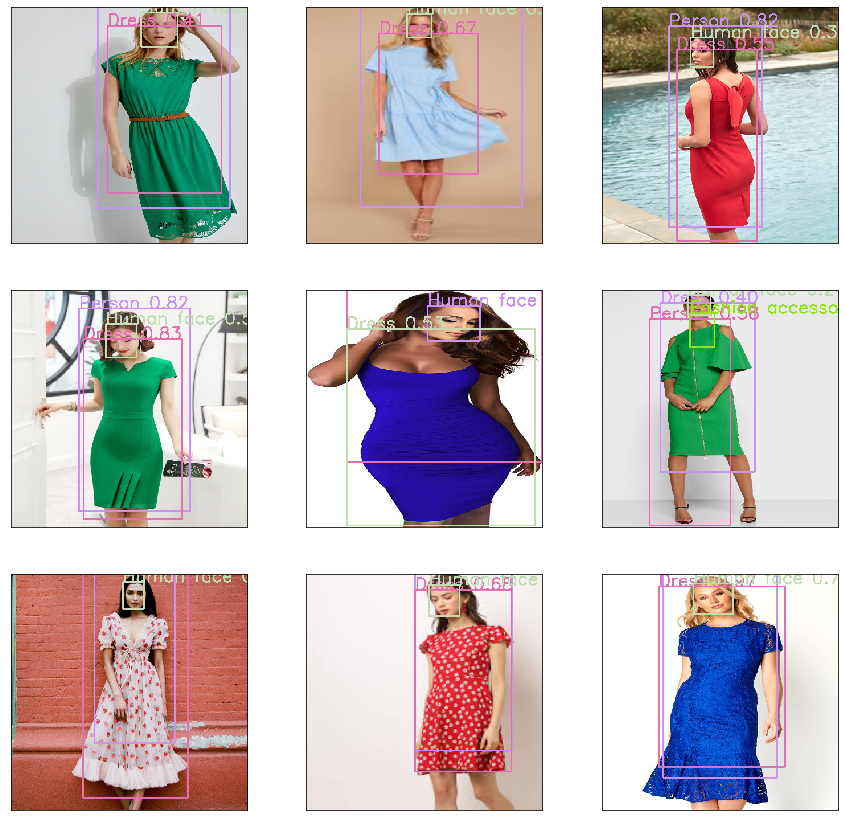

In [4]:
# Load detection model
detection_model = Model.from_sashdat(conn=s, 
                                     path='/data/notebooks/SAS_DeepLearning/Extracting_dominant_colors_of_images/model/Tiny-Yolov2.sashdat', 
                                     output_model_table='detection_model')
# Score images with loaded model
detection_table = detection_model.predict(data=image_table, gpu=1)
detection_table = detection_table['OutputCasTables']['casTable'][0]

# Display detection
display_object_detections(conn=s, 
                          coord_type='yolo', 
                          table=detection_table, 
                          fig_size=(15,20), 
                          n_col=3)

### Extract detections from original images
Each detected object will be cropped from its original image.<br>
We are getting one row per detection in our table.

In [7]:
detections = s.image.extractDetectedObjects(casOut=dict(name='detections', replace=True),
                                            table=dict(name=detection_table.name),
                                            extractType='crop',
                                            outputFormat='multiple_rows',
                                            coordtype='yolo')
detections = detections['OutputCasTables']['casTable'][0]
display(detections.head())

,_image_,_id_,_parentId_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0,1
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1,1
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2,1
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0,2
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1,2


### Add object detection data to extracted detetions
We transform our wide list of object detections to a long format where each detection is in a separate row.<br>
Afterwards we can use FedSQL to join our long object detection list and the extracted (cropped) detections.<br>
Finally we display all cropped detections in our dataset that our detection model classified as as dress.

Object detections in long format:



,_filename_0,_id_,_LABEL_,OBJECT_NUMBER,OBJECT_NAME,OBJECT_PROBABILITY,X,Y,WIDTH,HEIGHT
0,women_dress_blue3.jpg,5,5_0,0,Human face,0.643054,0.625559,0.143888,0.224782,0.153385
1,women_dress_red3.jpeg,8,8_2,2,Human face,0.498894,0.584725,0.118532,0.133373,0.136608
2,women_dress_blue2.jpeg,2,2_2,2,Human face,0.557789,0.480696,0.085889,0.107732,0.105492
3,women_dress_green.jpg,1,1_0,0,Person,0.877754,0.647156,0.427227,0.560304,0.854454
4,women_dress_blue2.jpeg,2,2_0,0,Person,0.639673,0.573477,0.425299,0.687397,0.850598


Object detections in long format joined with cropped image:



,_filename_0,_id_,_LABEL_,OBJECT_NUMBER,OBJECT_NAME,OBJECT_PROBABILITY,X,Y,WIDTH,HEIGHT,_image_
0,women_dress_blue3.jpg,5,5_0,0,Human face,0.643054,0.625559,0.143888,0.224782,0.153385,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,women_dress_red3.jpeg,8,8_2,2,Human face,0.498894,0.584725,0.118532,0.133373,0.136608,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,women_dress_blue2.jpeg,2,2_2,2,Human face,0.557789,0.480696,0.085889,0.107732,0.105492,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,women_dress_green.jpg,1,1_0,0,Person,0.877754,0.647156,0.427227,0.560304,0.854454,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,women_dress_blue2.jpeg,2,2_0,0,Person,0.639673,0.573477,0.425299,0.687397,0.850598,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...



Extracted Objects (filtered for "Dress"):


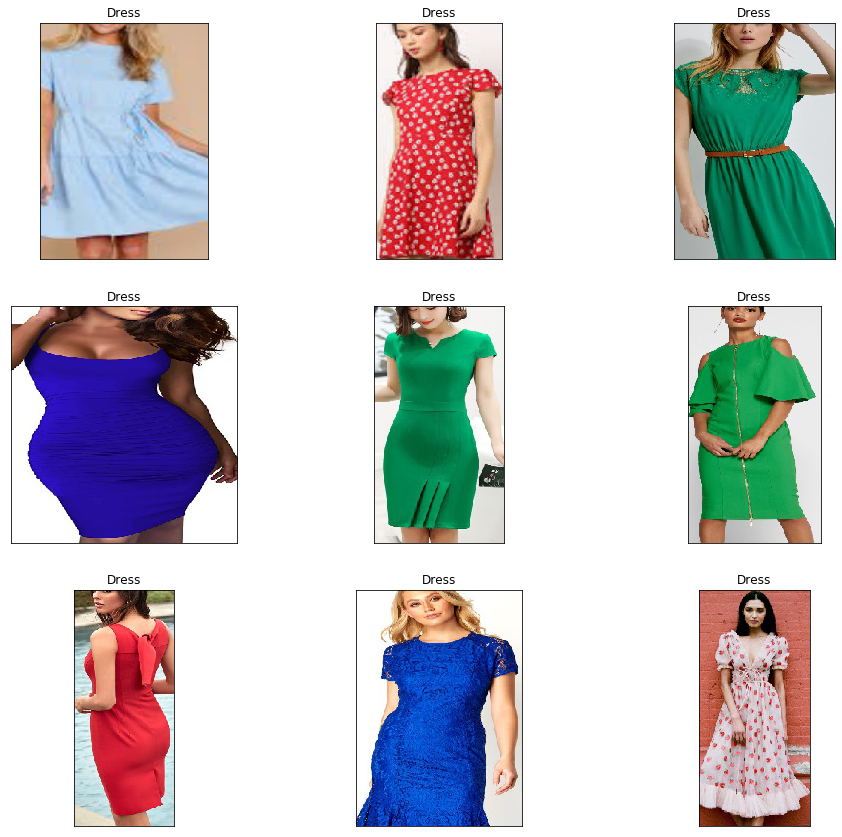

In [8]:
# Transform object detection table to long format (1 row per detected object)
detection_table_long = object_detections_wide_to_long(conn=s, 
                                                      input_table=detection_table.name, 
                                                      output_table='output', 
                                                      num_objects=7, 
                                                      replace=True)
print('Object detections in long format:\n')
display(detection_table_long.head())

# Join cropped images to long table
detection_table_long = fedsql_inner_join(conn=s, 
                                         left_table=detection_table_long.name, 
                                         right_table=detections.name, 
                                         output_table='outputtable',
                                         left_columns=['*'],
                                         right_columns=['_image_'],
                                         left_on=['_id_', 'OBJECT_NUMBER'], 
                                         right_on=['_parentId_', '_id_'], 
                                         replace=True)
print('Object detections in long format joined with cropped image:\n')
display(detection_table_long.head())
print('\nExtracted Objects (filtered for "Dress"):')
display_detections_long_table(detection_table_long, 
                              nimages=10, ncol=3, 
                              label_column='OBJECT_NAME', 
                              where='OBJECT_NAME="Dress"')

### Extract dominant colors from our images
This function uses Kmeans clustering for clustering the RGB pixel values into dominant colors.<br>
For each image we are getting between 2 and n clusters. The optimal number of clusters is automatically derived.<br>
Each cluster is then assigned to a predefined list of colors.<br>
This process is very computationally intensive. Reducing the image size can reduce the time required.

In [10]:
extracted_colors = extract_dominant_colors(conn=s, 
                                       image_table=detection_table_long, 
                                       image_column='_image_',
                                       output_table='extracted_colors', 
                                       image_width=50,
                                       image_height=50)
extracted_colors.head()

/opt/conda/envs/python_sas/lib/python3.7/site-packages/swat/dataframe.py:482: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result = super(SASDataFrame, self).__setitem__(*args, **kwargs)


,COLOR_NAME,COLOR_CLUSTER_SIZE,COLOR_CLUSTER_ID,COLOR_CLUSTER_PERCENT,R,G,B,_LABEL_,COLOR_GROUP,COLOR_R,COLOR_G,COLOR_B
0,sienna,233.0,0.0,9.32,146.008584,92.613734,67.433476,2_1,Brown,160.0,82.0,45.0
1,tan,795.0,1.0,31.80,202.705660,167.114465,140.854088,2_1,Brown,210.0,180.0,140.0
2,lightsteelblue,1472.0,2.0,58.88,174.762908,203.187500,230.421875,2_1,Blue,176.0,196.0,222.0
3,saddlebrown,216.0,0.0,8.64,106.527778,41.759259,32.962963,8_1,Brown,139.0,69.0,19.0
4,indianred,402.0,1.0,16.08,200.922886,101.753731,98.072139,8_1,Red,205.0,92.0,92.0


### Find objects by color
Now that we have our object detections and their dominant colors, we can search for specific objects with specific colors.


Red Dresses:


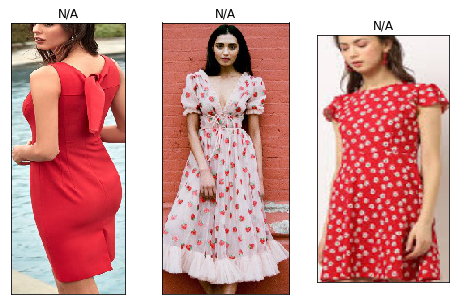

In [11]:
object_name = 'Dress'
object_color = 'Red'
color_cluster_min_size = 20# cluster size in percentage
res = find_object_by_color(conn=s, 
                           detection_table_long=detection_table_long, 
                           object_color_table=extracted_colors, 
                           output_table='out_red',
                           object_column='OBJECT_NAME',
                           object_name=object_name, 
                           color_column='COLOR_GROUP',
                           object_color=object_color, 
                           color_cluster_size_column='COLOR_CLUSTER_PERCENT', 
                           color_cluster_min_size=color_cluster_min_size,
                           id_column='_LABEL_',
                           replace=True)
print('\n{} Dresses:'.format(object_color))
res.show(figsize=(8,5))


Green Dresses:


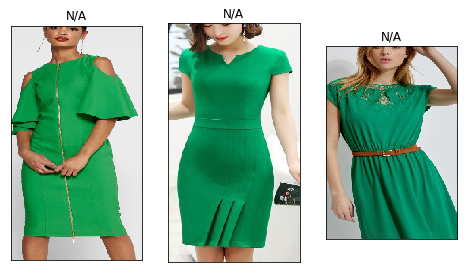

In [13]:
object_name = 'Dress'
object_color = 'Green'
color_cluster_min_size = 20# cluster size in percentage
res = find_object_by_color(conn=s, 
                           detection_table_long=detection_table_long, 
                           object_color_table=extracted_colors, 
                           output_table='out_green',
                           object_column='OBJECT_NAME',
                           object_name=object_name, 
                           color_column='COLOR_GROUP',
                           object_color=object_color, 
                           color_cluster_size_column='COLOR_CLUSTER_PERCENT', 
                           color_cluster_min_size=color_cluster_min_size,
                           id_column='_LABEL_',
                           replace=True)
print('\n{} Dresses:'.format(object_color))
res.show(figsize=(8,5))


Blue Dresses:


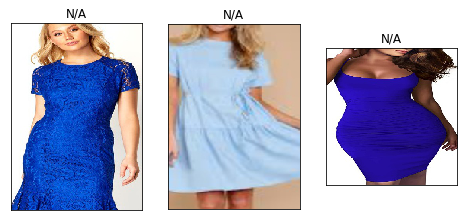

In [14]:
object_name = 'Dress'
object_color = 'Blue'
color_cluster_min_size = 10# cluster size in percentage
res = find_object_by_color(conn=s, 
                           detection_table_long=detection_table_long, 
                           object_color_table=extracted_colors, 
                           output_table='out_blue',
                           object_column='OBJECT_NAME',
                           object_name=object_name, 
                           color_column='COLOR_GROUP',
                           object_color=object_color, 
                           color_cluster_size_column='COLOR_CLUSTER_PERCENT', 
                           color_cluster_min_size=color_cluster_min_size,
                           id_column='_LABEL_',
                           replace=True)
print('\n{} Dresses:'.format(object_color))
res.show(figsize=(8,5))